## Predicted Tracking Error Rebalance Portfolio

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ffn
import bt

%matplotlib inline

### Create Fake Index Data

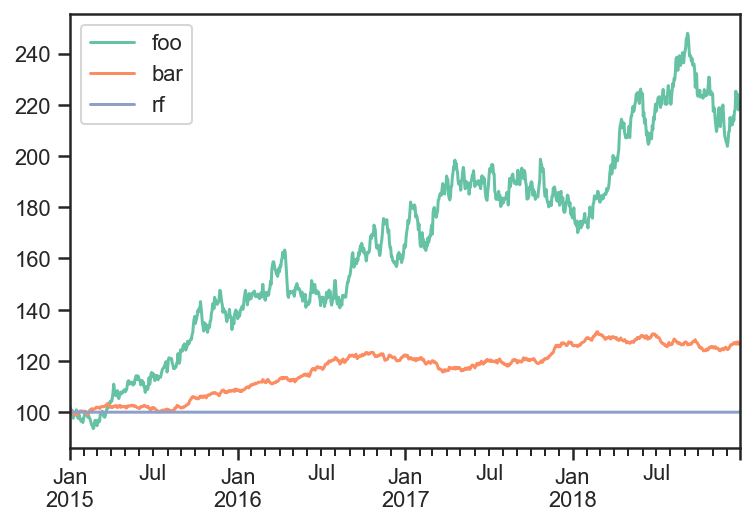

In [16]:
names = ['foo','bar','rf']
dates = pd.date_range(start='2015-01-01',end='2018-12-31', freq=pd.tseries.offsets.BDay())
n = len(dates)
rdf = pd.DataFrame(
    np.zeros((n, len(names))),
    index = dates,
    columns = names
)

np.random.seed(1)
rdf['foo'] = np.random.normal(loc = 0.1/252,scale=0.2/np.sqrt(252),size=n)
rdf['bar'] = np.random.normal(loc = 0.04/252,scale=0.05/np.sqrt(252),size=n)
rdf['rf'] = 0.

pdf = 100*np.cumprod(1+rdf)
pdf.plot();

### Build and run Target Strategy

I will first run a strategy that rebalances everyday.

Then I will use those weights as target to rebalance to whenever the PTE is too high.

In [17]:
selectTheseAlgo = bt.algos.SelectThese(['foo','bar'])

# algo to set the weights to 1/vol contributions from each asset
#  with data over the last 3 months excluding yesterday
weighInvVolAlgo = bt.algos.WeighInvVol(
    lookback=pd.DateOffset(months=3),
    lag=pd.DateOffset(days=1)
)

# algo to rebalance the current weights to weights set in target.temp
rebalAlgo = bt.algos.Rebalance()

# a strategy that rebalances daily to 1/vol weights
strat = bt.Strategy(
    'Target',
    [
        selectTheseAlgo,
        weighInvVolAlgo,
        rebalAlgo
    ]
)

# set integer_positions=False when positions are not required to be integers(round numbers)
backtest = bt.Backtest(
    strat,
    pdf,
    integer_positions=False
)

res_target = bt.run(backtest)

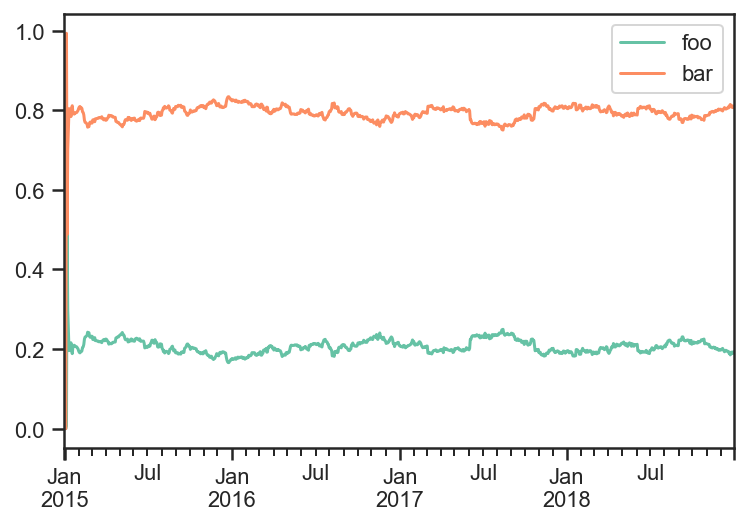

In [18]:
res_target.get_security_weights().plot();

Now use the PTE rebalance algo to trigger a rebalance whenever predicted tracking error is greater than 1%.

In [19]:
# algo to fire whenever predicted tracking error is greater than 1%
wdf = res_target.get_security_weights()

PTE_rebalance_Algo = bt.algos.PTE_Rebalance(
    0.01,
    wdf,
    lookback=pd.DateOffset(months=3),
    lag=pd.DateOffset(days=1),
    covar_method='standard',
    annualization_factor=252
)

selectTheseAlgo = bt.algos.SelectThese(['foo','bar'])

# algo to set the weights to 1/vol contributions from each asset
#  with data over the last 12 months excluding yesterday
weighTargetAlgo = bt.algos.WeighTarget(
    wdf
)

rebalAlgo = bt.algos.Rebalance()

# a strategy that rebalances monthly to specified weights
strat = bt.Strategy(
    'PTE',
    [
        PTE_rebalance_Algo,
        selectTheseAlgo,
        weighTargetAlgo,
        rebalAlgo
    ]
)

# set integer_positions=False when positions are not required to be integers(round numbers)
backtest = bt.Backtest(
    strat,
    pdf,
    integer_positions=False
)

res_PTE = bt.run(backtest)

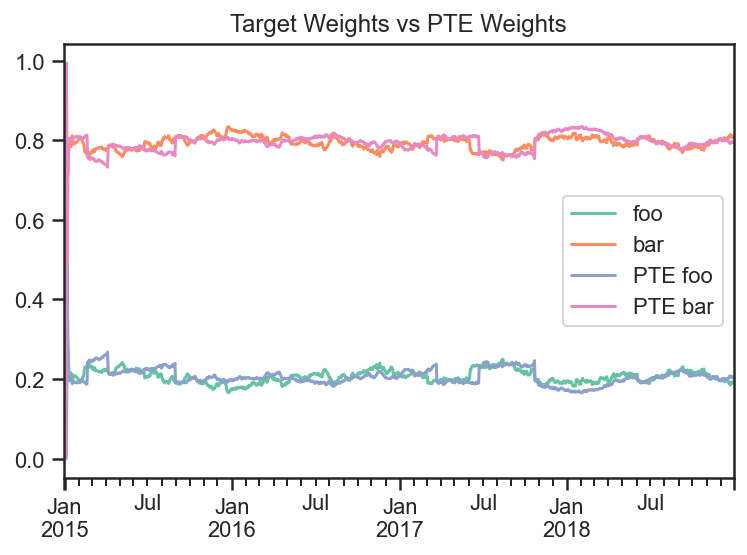

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=1)
res_target.get_security_weights().plot(ax=ax)

realized_weights_df = res_PTE.get_security_weights()
realized_weights_df['PTE foo'] = realized_weights_df['foo']
realized_weights_df['PTE bar'] = realized_weights_df['bar']
realized_weights_df = realized_weights_df.loc[:,['PTE foo', 'PTE bar']]
realized_weights_df.plot(ax=ax)

ax.set_title('Target Weights vs PTE Weights')
ax.plot();

In [21]:
trans_df = pd.DataFrame(
    index=res_target.prices.index,
    columns=['Target','PTE']
)

transactions = res_target.get_transactions()
transactions = (transactions['quantity'] * transactions['price']).reset_index()

bar_mask = transactions.loc[:,'Security'] == 'bar'
foo_mask = transactions.loc[:,'Security'] == 'foo'

trans_df.loc[trans_df.index[4:],'Target'] = np.abs(transactions[bar_mask].iloc[:,2].values) + np.abs(transactions[foo_mask].iloc[:,2].values)


In [22]:
transactions = res_PTE.get_transactions()
transactions = (transactions['quantity'] * transactions['price']).reset_index()

bar_mask = transactions.loc[:,'Security'] == 'bar'
foo_mask = transactions.loc[:,'Security'] == 'foo'

trans_df.loc[transactions[bar_mask].iloc[:,0],'PTE'] =  np.abs(transactions[bar_mask].iloc[:,2].values)
trans_df.loc[transactions[foo_mask].iloc[:,0],'PTE'] +=  np.abs(transactions[foo_mask].iloc[:,2].values)


In [23]:
trans_df = trans_df.fillna(0)

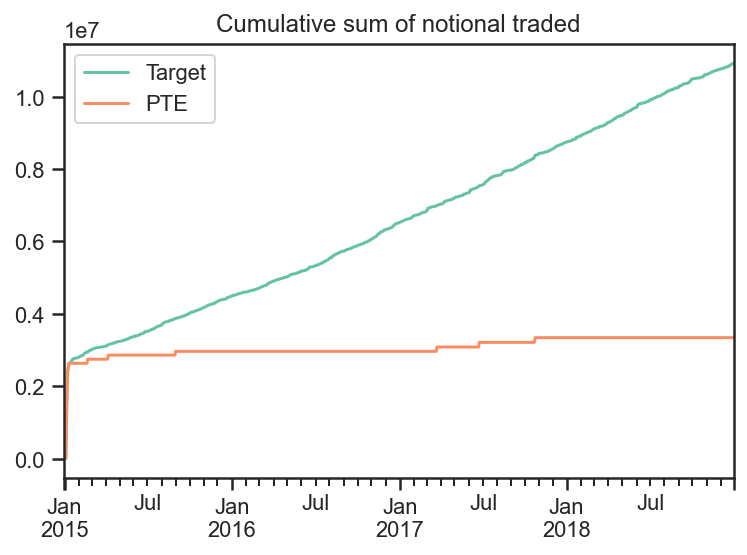

In [24]:
fig, ax = plt.subplots(nrows=1,ncols=1)
trans_df.cumsum().plot(ax=ax)
ax.set_title('Cumulative sum of notional traded')
ax.plot();

If we plot the total risk contribution of each asset class and divide by the total volatility, then we can see that both strategy's contribute roughly similar amounts of volatility from both of the securities.

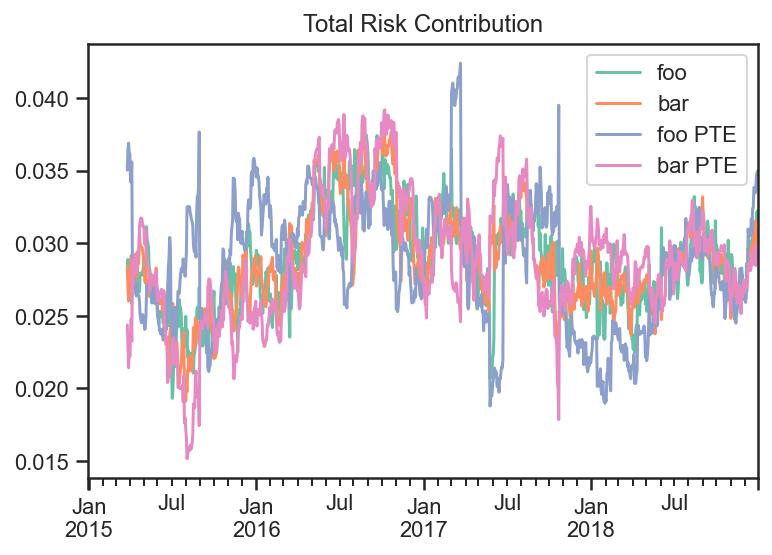

In [25]:
weights_target = res_target.get_security_weights()
rolling_cov_target = pdf.loc[:,weights_target.columns].pct_change().rolling(window=3*20).cov()*252

weights_PTE = res_PTE.get_security_weights().loc[:,weights_target.columns]
rolling_cov_PTE = pdf.loc[:,weights_target.columns].pct_change().rolling(window=3*20).cov()*252


trc_target = pd.DataFrame(
    np.nan,
    index = weights_target.index,
    columns = weights_target.columns
)

trc_PTE = pd.DataFrame(
    np.nan,
    index = weights_PTE.index,
    columns = [x + " PTE" for x in weights_PTE.columns]
)

for dt in pdf.index:
    trc_target.loc[dt,:] = weights_target.loc[dt,:].values*(rolling_cov_target.loc[dt,:].values@weights_target.loc[dt,:].values)/np.sqrt(weights_target.loc[dt,:].values@rolling_cov_target.loc[dt,:].values@weights_target.loc[dt,:].values)
    trc_PTE.loc[dt,:] = weights_PTE.loc[dt,:].values*(rolling_cov_PTE.loc[dt,:].values@weights_PTE.loc[dt,:].values)/np.sqrt(weights_PTE.loc[dt,:].values@rolling_cov_PTE.loc[dt,:].values@weights_PTE.loc[dt,:].values)


fig, ax = plt.subplots(nrows=1,ncols=1)
trc_target.plot(ax=ax)
trc_PTE.plot(ax=ax)
ax.set_title('Total Risk Contribution')
ax.plot();

Looking at the Target strategy's and PTE strategy's Total Risk they are very similar.

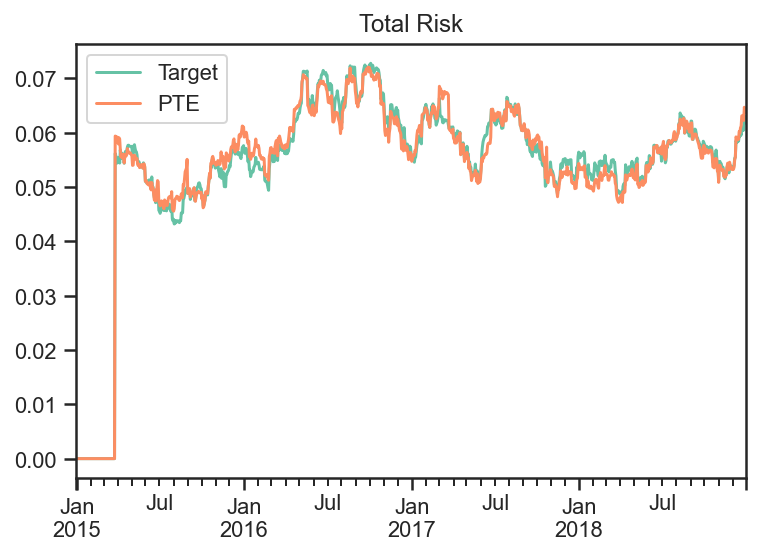

In [26]:
fig, ax = plt.subplots(nrows=1,ncols=1)
trc_target.sum(axis=1).plot(ax=ax,label='Target')
trc_PTE.sum(axis=1).plot(ax=ax,label='PTE')
ax.legend()
ax.set_title('Total Risk')
ax.plot();

In [27]:
transactions = res_PTE.get_transactions()
transactions = (transactions['quantity'] * transactions['price']).reset_index()

bar_mask = transactions.loc[:,'Security'] == 'bar'
dates_of_PTE_transactions = transactions[bar_mask].iloc[:,0]
dates_of_PTE_transactions

0    2015-01-06
2    2015-01-07
4    2015-01-08
6    2015-01-09
8    2015-01-12
10   2015-02-20
12   2015-04-07
14   2015-09-01
16   2017-03-23
18   2017-06-23
20   2017-10-24
Name: Date, dtype: datetime64[ns]

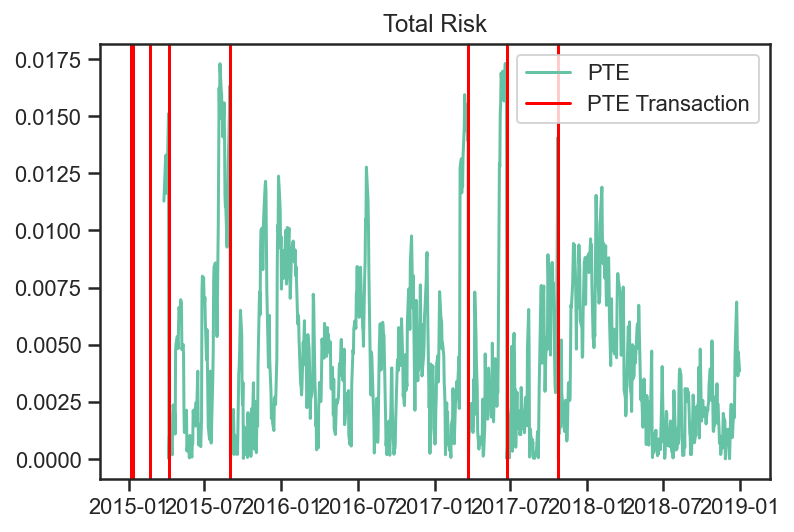

In [28]:
fig, ax = plt.subplots(nrows=1,ncols=1)
np.sum(np.abs(trc_target.values - trc_PTE.values))
    #.abs().sum(axis=1).plot()

ax.set_title('Total Risk')
ax.plot(
    trc_target.index,
    np.sum(np.abs(trc_target.values - trc_PTE.values),axis=1),
    label='PTE'
)

for i,dt in enumerate(dates_of_PTE_transactions):
    if i == 0:
        ax.axvline(x=dt,color='red',label='PTE Transaction')
    else:
        ax.axvline(x=dt,color='red')

ax.legend();


We can see the Predicted Tracking Error of the PTE Strategy with each transaction marked.